In [1]:
%pylab inline
from astropy.cosmology import WMAP9
from simqso.sqrun import generate_default_binned_forest
from simqso.hiforest import MeanIGMTransmissionGrid
from simqso import sqmodels
from simqso.sqgrids import *
from simqso.sqbase import fixed_R_dispersion
from simqso.sqrun import buildSpectraBulk

Populating the interactive namespace from numpy and matplotlib


In [2]:
wave = fixed_R_dispersion(3000,1.1e4,1000)

In [3]:
binnedForestFile = 'forest_grid_2500'
#generate_default_binned_forest(binnedForestFile,numSightlines=2500)
forest = MeanIGMTransmissionGrid(binnedForestFile,wave)
igmAbs = HIAbsorptionVar(forest)

In [4]:
Mbins = linspace(-30,-20,11)
M = AbsMagVar(FixedSampler(Mbins),1450)
z = RedshiftVar(FixedSampler(forest.zBins))
qsoGrid = QsoSimGrid([M,z],(None,None),1,fixed_vars=['absMag','z'],
                     cosmo=WMAP9,units='luminosity')

In [5]:
plcont = BrokenPowerLawContinuumVar([ConstSampler(-1.5),
                                     ConstSampler(-0.44)],
                                   [1100])
emlines = sqmodels.BossDr9_EmLineTemplate(qsoGrid.absMag,
                                          NoScatter=True)
fetempl = VW01FeTemplateGrid(qsoGrid.z,wave,
                             scales=sqmodels.BossDr9_FeScalings)
feVar = FeTemplateVar(fetempl)
qsoGrid.addVars([plcont,emlines,feVar,igmAbs])

In [6]:
qsoGrid.loadPhotoMap([('SDSS','Legacy'),])

In [7]:
_ = buildSpectraBulk(wave,qsoGrid)

simulating  1980  quasar spectra
units are  luminosity
buildSpectra iteration  1  out of  1


In [8]:
mags = qsoGrid.asGrid('synMag').squeeze()
colors = -np.diff(mags,axis=-1)

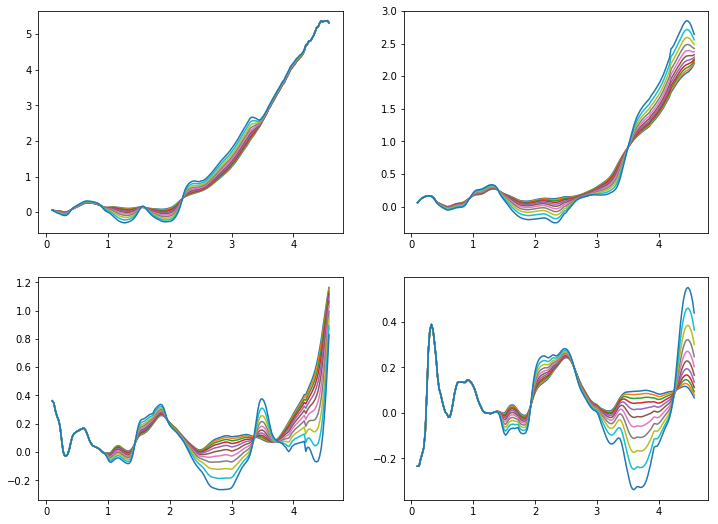

In [9]:
figure(figsize=(12,9))
for pnum,cc in enumerate(range(4),start=1):
    subplot(2,2,pnum)
    plot(forest.zBins,colors[...,cc].T)

In [10]:
M = qsoGrid.asGrid('absMag')
DM = qsoGrid.distMod(qsoGrid.asGrid('z'))
kcorr = mags - (M + DM)

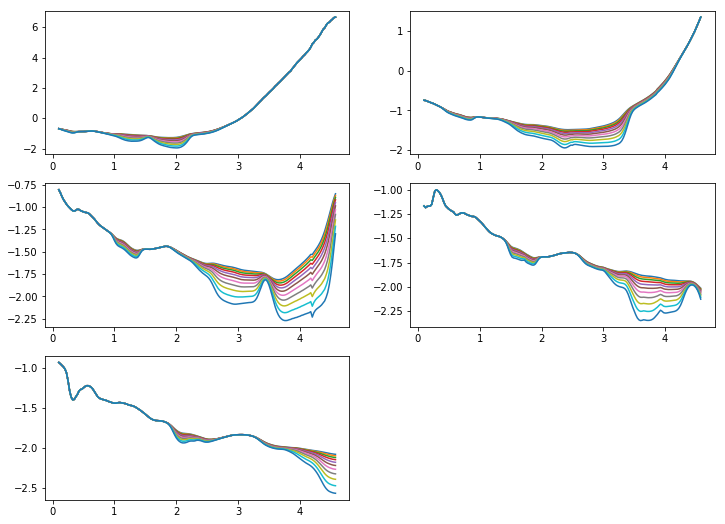

In [11]:
figure(figsize=(12,9))
for pnum,j in enumerate(range(5),start=1):
    subplot(3,2,pnum)
    plot(forest.zBins,kcorr[...,j].T)

In [12]:
savez('bossdr9kcorr_ugriz.npz',mbins=mags,Mbins=Mbins,zbins=forest.zBins,kcorr=kcorr)